In [ ]:
%load_ext autoreload
%autoreload 2
# default_exp indexers.facerecognition.model

In [ ]:
# export
from integrators.data.schema import *
from integrators.data.basic import *
from integrators.data.itembase import *
from integrators.pod.client import PodClient
from integrators.indexers.indexer import IndexerBase, get_indexer_run_data, IndexerData, test_registration
from integrators.indexers import *
from integrators.imports import *
from integrators.indexers.facerecognition.photo import *
from fastprogress.fastprogress import progress_bar

# FaceRecognition models

The `FaceRecognitionModel` recognizes face from photos. Behind the scenes it uses the arcface model from deepinsight to make predictions. The model does both face detection (creating bouding boxes around faces) and face recognition (compare faces and check for similarity).

In [ ]:
# export
from insightface.model_zoo.face_recognition import FaceRecognition
from insightface.model_zoo.face_detection import FaceDetector

In [ ]:
# export
# hide
RETINAFACE_URL = f"{MEMRI_S3}/retinaface_r50_v1.zip"
ARCFACE_URL    = f"{MEMRI_S3}/arcface_r100_v1.zip"

def arcface_r100_v1():    
    zipfile = MODEL_DIR / "arcface_r100_v1.zip"
    download_file(ARCFACE_URL, zipfile)
    unzipped = zipfile.with_suffix("")
    if not (unzipped / "model-symbol.json").exists(): unzip(zipfile, unzipped)
    params_file = str(unzipped / "model-0000.params")
    return FaceRecognition("r100_v1", True, params_file)
    
def retinaface_r50_v1():
    zipfile = MODEL_DIR / "retinaface_r50_v1.zip"
    download_file(RETINAFACE_URL, zipfile)
    unzipped = zipfile.with_suffix("")
    if not (unzipped / "R50-symbol.json").exists(): unzip(zipfile, unzipped)
    params_file = str(unzipped / "R50-0000.params")
    return FaceDetector(params_file, rac="net3")

In [ ]:
# export
class FaceRecognitionModel():
    """Recognizes photos from faces."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.recognition_model = arcface_r100_v1()
        self.recognition_model.prepare(-1);
        self.detection_model = retinaface_r50_v1()
        self.detection_model.prepare(-1);

    def compare(self, img1, img2):
        sim = round(float(self.recognition_model.compute_sim(img1, img2)), 2)
        return sim
        
    def predict_boundingboxes(self, iphoto):
        boxes, landmarks = self.detection_model.detect(iphoto.data)
        return boxes, landmarks
    
    def get_embedding(self, img, normalized=True):
        x = img.data if isinstance(img, IPhoto) else img
        return self.recognition_model.get_embedding(x).flatten()
    
    def get_crops(self, photos):
        crop_photos = []
        for i, photo in enumerate(progress_bar(photos)):
            boxes, landmarks = self.predict_boundingboxes(photo)
            crop_photos += [IPhoto.from_np(c) for c in photo.get_crops(boxes, landmarks)]
        return crop_photos

# Usage

Lets initialize a FaceRecognitionIndexer and see how we can use it.

In [ ]:
# hide_output
indexer = FaceRecognitionModel()

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


In [ ]:
photo = IPhoto.from_path(path=PYI_TESTDATA / "photos" / "facerecognition" / "celebs.jpg")
boxes, landmarks = indexer.predict_boundingboxes(photo)

Plotting 12 face boundingboxes


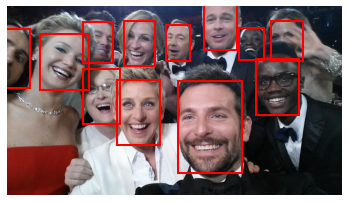

In [ ]:
photo.draw_boxes(boxes)

In [ ]:
crops = photo.get_crops(boxes, landmarks)

Lets get two random faces from our photo

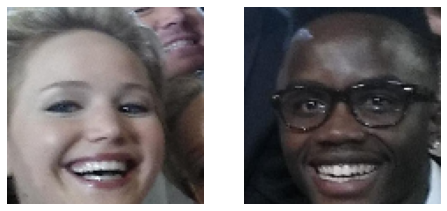

In [ ]:
show_images([crops[0], crops[1]])

And check if they are the same

In [ ]:
try:
    similarity =  indexer.compare(crops[0], crops[1])
    assert similarity < 0.5
finally:
    print("Not the same person")

Not the same person


## Compute similarity for photo's of the same person

In [ ]:
ellen1 = IPhoto.from_path(path=PYI_TESTDATA / "photos" / "facerecognition" / "ellen1.png")
ellen2 = IPhoto.from_path(path=PYI_TESTDATA / "photos" / "facerecognition" / "ellen2.png")

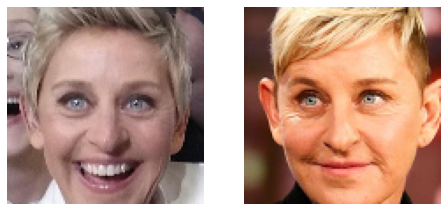

In [ ]:
show_images([ellen1.data, ellen2.data])

In [ ]:
try:
    sim = indexer.compare(ellen1.data, ellen2.data)
    assert sim > 0.5
finally:
    print("Same person")

Same person


## Plotting crops

When we plot the crops, we see that our model actually is doing some magic behind the scenes to normalize and scale our images.

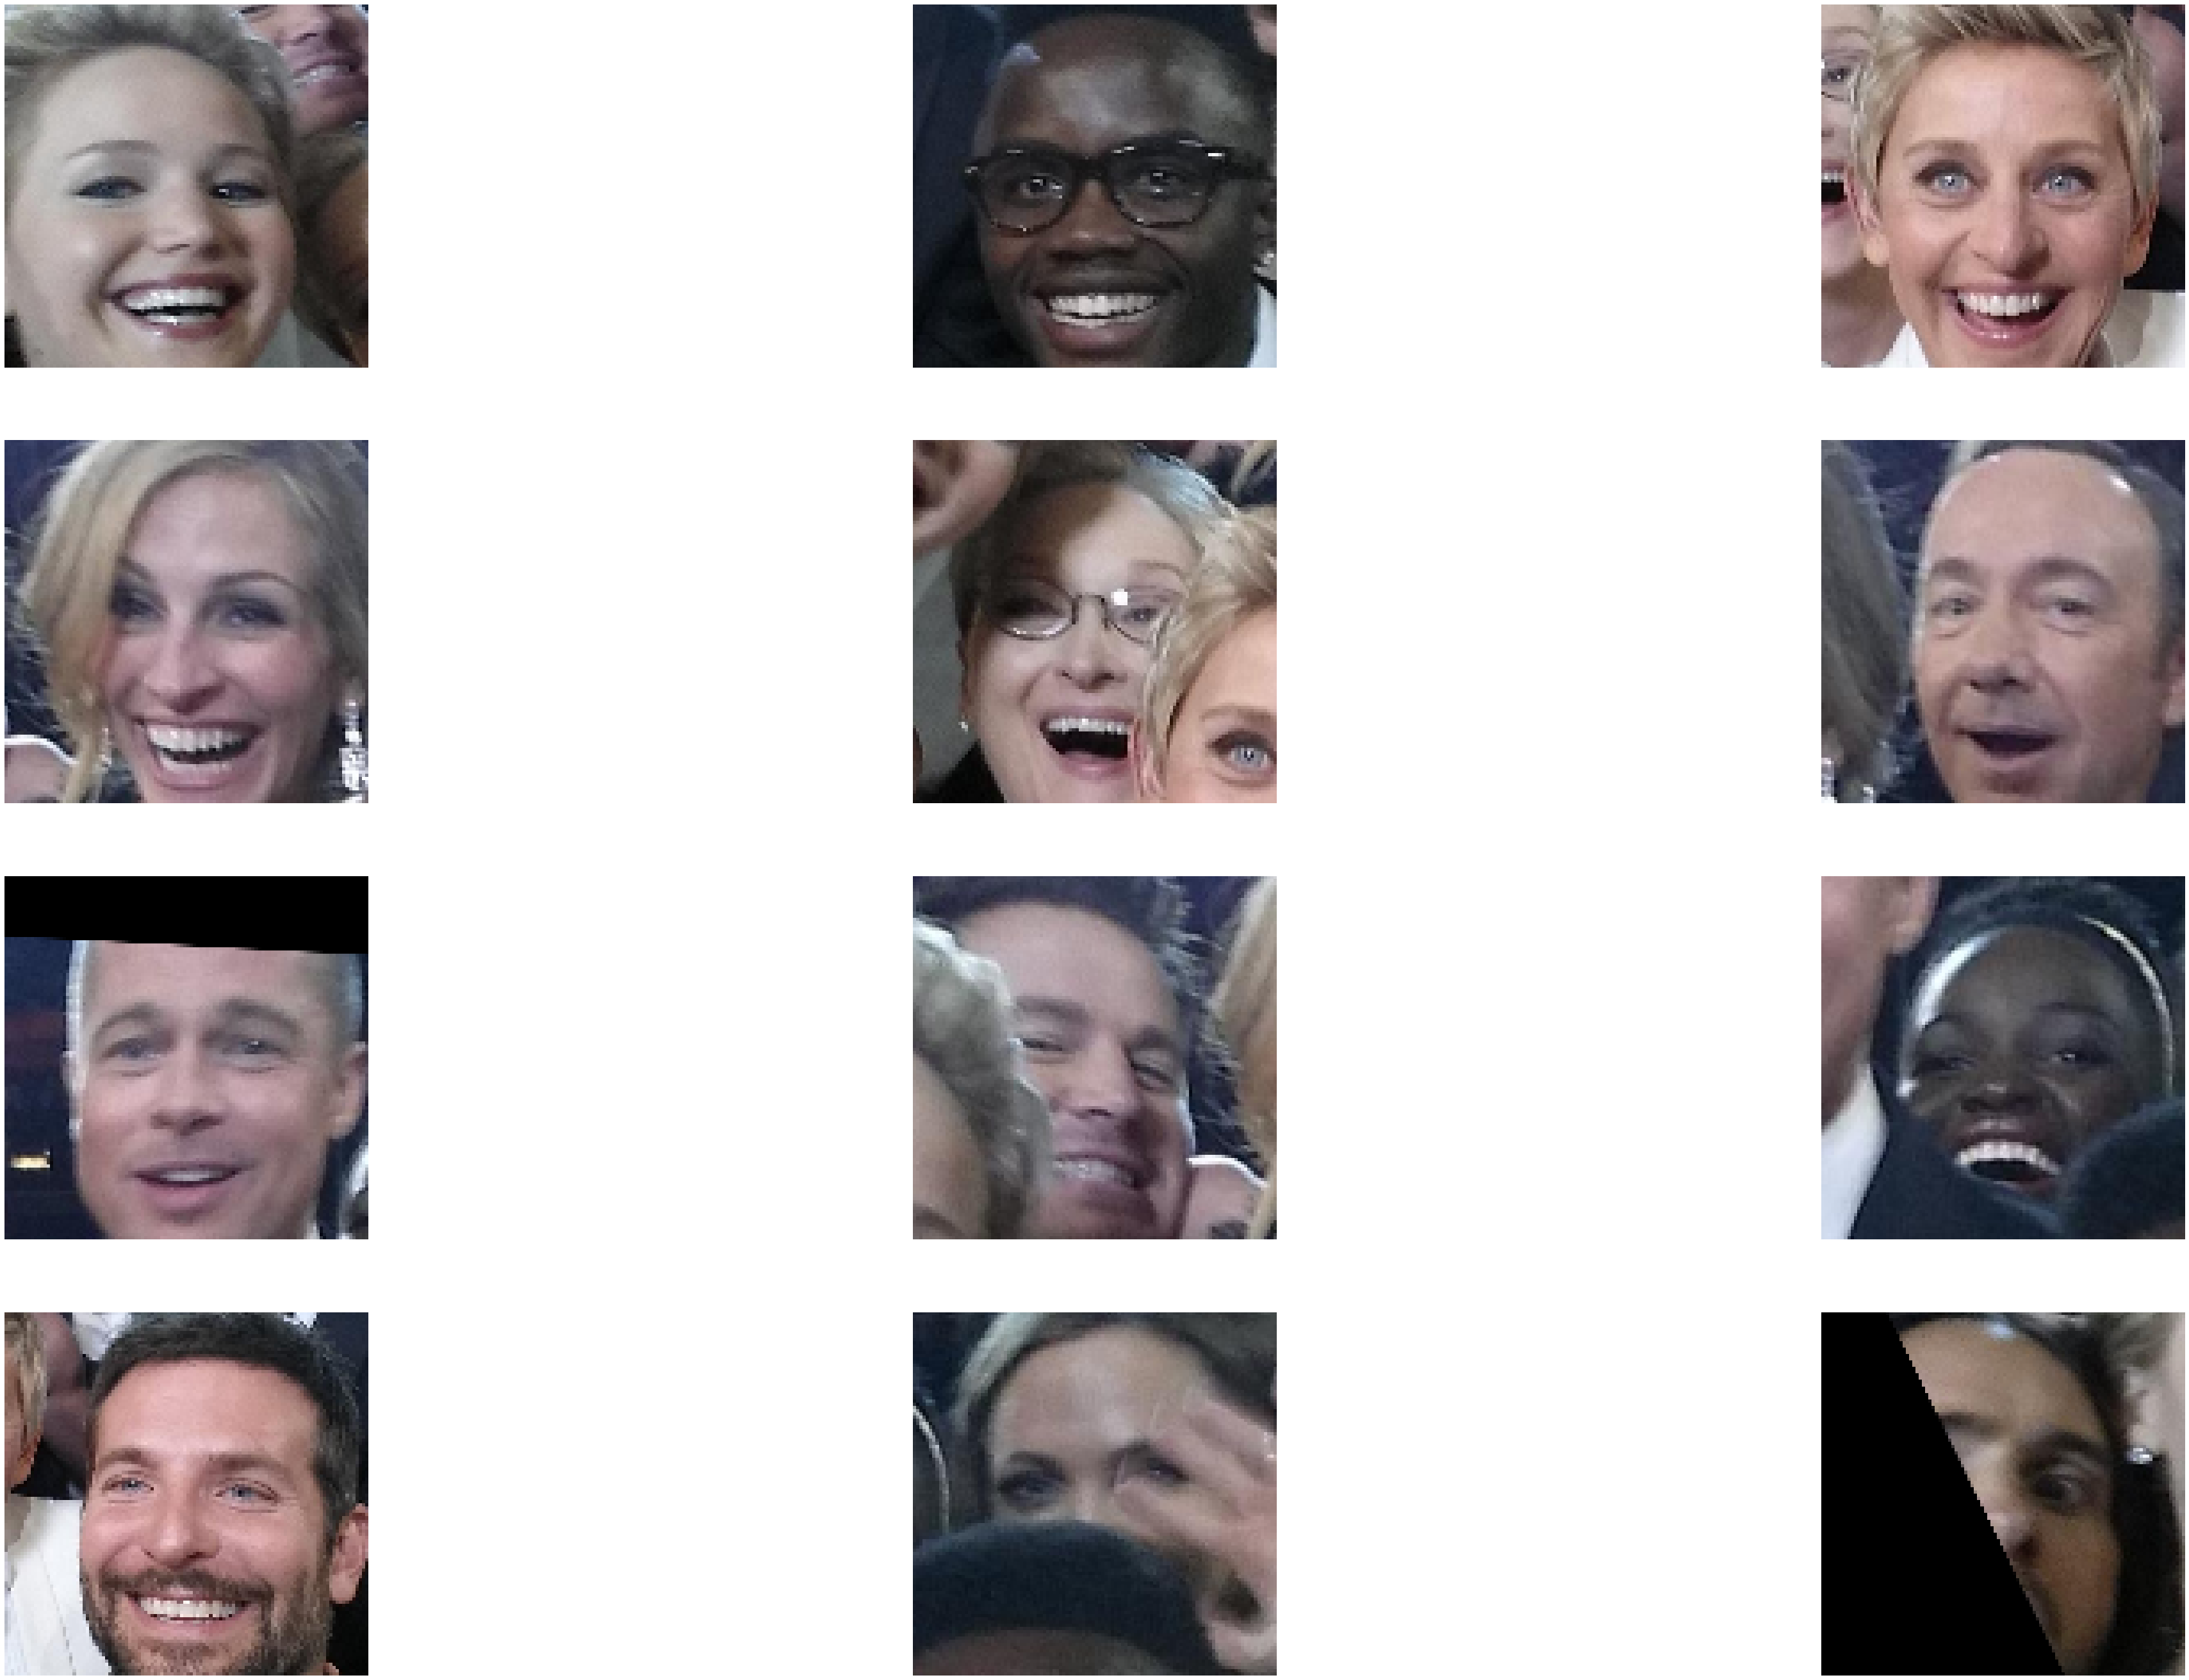

In [ ]:
photo.plot_crops(boxes, landmarks)

# Export -

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted basic.ipynb.
Converted importers.EmailImporter.ipynb.
Converted importers.Importer.ipynb.
Converted importers.util.ipynb.
Converted index.ipynb.
Converted indexers.FaceClusteringIndexer.Models.ipynb.
Converted indexers.FaceClusteringIndexer.Utils.ipynb.
Converted indexers.FaceClusteringIndexer.indexer.ipynb.
Converted indexers.FaceRecognitionModel.ipynb.
Converted indexers.FacerecognitionIndexer.Photo.ipynb.
Converted indexers.GeoIndexer.ipynb.
Converted indexers.NoteListIndexer.NoteList.ipynb.
Converted indexers.NoteListIndexer.Parser.ipynb.
Converted indexers.NoteListIndexer.ipynb.
Converted indexers.NoteListIndexer.util.ipynb.
Converted indexers.indexer.ipynb.
Converted itembase.ipynb.
Converted pod.client.ipynb.
